# Essais de réseaux de neurones pour le projet

In [1]:
import gzip
import time
import numpy
import numpy as np
import shutil
import scipy.constants as cst
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as T
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30, 20)
from matplotlib import pyplot as plt
import os
import cmath
j = cmath.sqrt(-1)



In [2]:
## UTILS
def compute_numerical_derivative3(x, y):
    res = np.zeros_like(y) # 'd' for double
    # centered differences
    x_dif = x[2:] - x[:-2]
    y_dif = y[2:] - y[:-2]
    res[1:-1] = y_dif / x_dif
    res[0] = (y[1] - y[0]) / (x[1] - x[0])
    res[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return res
def wrap_angle(unwrapped_phase):
    return np.angle(np.exp(1j*unwrapped_phase))

def get_number_params(model):
    s = 0
    params = model.parameters()
    for p in params:
        ss=1
        for u in p.shape:
            ss = u*ss      
        s +=ss
    return s

In [53]:
## DATASET 
class CDCDataset(Dataset):
    def __init__(self, path, set_type="train"):
        super().__init__()
        # garde les paramètres en mémoire
        self.path = path
        # charger les données
        self.tx1 = torch.load('tX1.pt')
        self.tx2 = torch.load('tX2.pt')
        self.ty = torch.load('ty.pt')
        
        dataset_size = len(self.ty)
        self.lambda_ = np.linspace(1500e-9,1600e-9,1001)
        self.omega = 2*np.pi*cst.c/self.lambda_ 
        yi = torch.Tensor(self.tx1.shape[0],int(self.tx1.shape[1]/2))
        yr = torch.Tensor(self.tx1.shape[0],int(self.tx1.shape[1]/2))
        y_reshape = torch.reshape(self.tx1,(self.tx1.shape[0],2,int(self.tx1.shape[1]/2)))
        yr[:,:] = y_reshape[:,0,:]
        yi[:,:] = y_reshape[:,1,:]

        x = torch.Tensor(self.tx2.shape[0],3,int(self.tx2.shape[1]/2-1))
        x_reshape = torch.reshape(self.tx2,(len(self.ty),2,101))
        x[:,0,:] = ((x_reshape[:,0,:-1])/50000)
        x[:,1,:] = (((x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1]))/(torch.max(x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1])))
        x[:,2,:] = (self.ty[:,1]/torch.max(self.ty[:,1])).unsqueeze(-1).expand(len(self.ty),100)       
        X = []
        Y = []
        Y2 = []
        angle = []
        self.data =[] 
        
        
        for i in range(dataset_size): 
            angle.append(torch.Tensor(np.unwrap(np.angle(yr[i,:].cpu().numpy()+1j*yi[i,:].cpu().numpy()),discont=cst.pi)))
            X.append(x[i])# D.append(X2[i].unsqueeze(0))
            y=10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2))
            Y.append(10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2)))#     U.append(10*np.log10(np.abs(Y2[i,:])**2))      
            self.data .append([x[i],y]) #Data.append([X2[i].unsqueeze(0),Y2[i,:]]) #
            Y2.append(torch.stack([Y[i],angle[i]],0).view(2002))
        indices = list(range(dataset_size))
        split = int(np.floor(0.25 * dataset_size))
        np.random.seed(3)
        np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]
        
        
        if set_type is "train":        
            self.angle = [angle[i] for i in train_indices]
            self.X = [X[i] for i in train_indices]
            self.Y = [Y[i] for i in train_indices]
            self.Y2 = [Y2[i] for i in train_indices]
        elif set_type is "test":
            self.angle = [angle[i] for i in test_indices]
            self.X = [X[i] for i in test_indices]
            self.Y = [Y[i] for i in test_indices] 
            self.Y2 = [Y2[i] for i in test_indices]
    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y2[index]
        return X,Y   
    def __len__(self):
        # TODO Q1A
        return len(self.Y)


In [5]:
## CLASS POUR DENSENET
class DenseBlock(nn.Module):
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__() 
        self.relu = nn.LeakyReLU(inplace = True)
        self.bn = nn.BatchNorm1d(num_features = in_channels)
        self.conv1 = nn.ConvTranspose1d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.ConvTranspose1d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.ConvTranspose1d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.ConvTranspose1d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.ConvTranspose1d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)  
    def forward(self, x):
        batch_size = x.shape[0]
        bn = self.bn(x)
        conv1 = self.relu(self.conv1(bn))
        conv2 = self.relu(self.conv2(conv1))
        c2_dense = self.relu(torch.cat([conv1, conv2], 1))
        conv3 = self.relu(self.conv3(c2_dense))
        c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
        conv4 = self.relu(self.conv4(c3_dense))
        c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1)) 
        conv5 = self.relu(self.conv5(c4_dense))
        c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
        x = c5_dense

        return x 
class Transition_Layer(nn.Module):
    def __init__(self, in_channels, out_channels): 
        super(Transition_Layer, self).__init__()   
        self.relu = nn.LeakyReLU(inplace = True)
        self.bn = nn.BatchNorm1d(out_channels)
        self.conv = nn.ConvTranspose1d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False) 
        self.avg_pool = nn.AvgPool1d(kernel_size = 2, stride = 2, padding = 0) 
    def forward(self, x):
        bn = self.bn(self.relu(self.conv(x)))
        out = self.avg_pool(bn) 
        return bn   



In [249]:
class DenseNet(nn.Module): 
    def __init__(self, nr_classes,batch_size): 
        super(DenseNet, self).__init__()
        self.batch_size = batch_size
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False) 
        self.relu = nn.ReLU()
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 64) 
        self.denseblock2 = self._make_dense_block(DenseBlock, 128)
        self.denseblock3 = self._make_dense_block(DenseBlock, 128)    # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)    # Classifier 
        self.bn = nn.BatchNorm1d(num_features = 64)
        self.fc1 = nn.Sequential(nn.Linear(64*100,8),
                                 nn.ReLU(),
                                 nn.Linear(8,100),
                                 nn.ReLU(),
                                 nn.Linear(100,nr_classes))
        self.fc2 = nn.Sequential(nn.Linear(64*100,100),
                                 nn.ReLU(),
                                 nn.Linear(100,nr_classes))
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)
        out = self.denseblock2(out) 
        out = self.transitionLayer2(out) 
        out = self.denseblock3(out) 
        out = self.transitionLayer3(out) 
        out = self.bn(out) 
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy()) 
#         out = stop
        out = out.view(batch_size,64*100,-1).mean(dim=1) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())      
        out1 = self.fc1(out)
        out2 = self.fc2(out)

        return out1,out2

In [263]:
class DenseNet2(nn.Module): 
    def __init__(self, nr_classes,batch_size): 
        super(DenseNet2, self).__init__()
        self.batch_size = batch_size
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 32)
        self.denseblock2 = self._make_dense_block(DenseBlock, 64)
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64) 

        self.bn = nn.BatchNorm1d(num_features = 64)
        self.fc1 = nn.Sequential(nn.Linear(100*64,50),
#                                  nn.ReLU(),
#                                  nn.Linear(64,32),
                                 nn.ReLU(),
                                 nn.Linear(50,nr_classes))
        self.fc2 = nn.Sequential(nn.Linear(100*64,50),
                                 nn.ReLU(),
                                 nn.Linear(50,nr_classes))
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
#         print(out.shape)
#         out = stop
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)
        out = self.denseblock2(out) 
        out = self.transitionLayer2(out) 
        out = self.bn(out)
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy())
#         out = stop
        out = out.view(batch_size,100*64,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
#         out = out.view(batch_size*100*100) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())
#         out = stop
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        return out1,out2

In [141]:
class DenseNet1(nn.Module): 
    def __init__(self, nr_classes,batch_size): 
        super(DenseNet1, self).__init__()
        self.batch_size = batch_size
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 32)   
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64) 
        self.bn = nn.BatchNorm1d(num_features = 64)
        self.fc1 = nn.Sequential(nn.Linear(100*64,100),
                                 nn.ReLU(),
                                 nn.Linear(100,nr_classes))
        self.fc2 = nn.Sequential(nn.Linear(100*64,100),
                                 nn.ReLU(),
                                 nn.Linear(100,nr_classes))
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
#         print(out.shape)
#         out = stop
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)     
        out = self.bn(out)
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy())
#         out = stop
        out = out.view(batch_size,100*64,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
#         out = out.view(batch_size*100*100) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())
#         out = stop
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        return out1,out2

In [219]:
## INIT TRAINING PARAMETERS
# Définit si cuda est utilisé ou non
# mettre cuda pour utiliser un GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Définit les paramètres d'entraînement
# Nous vous conseillons ces paramètres. 
dataset_train = CDCDataset("JC/Data/Dataset_v0.txt","train")

In [296]:
## TRAINING
batch_size = 40
nb_epoch = 50
learning_rate = 0.001
momentum = 0.9

valid_split = 0.05
shuffle_dataset = True
random_seed= 20
dataset_size = len(dataset_train)
indices = list(range(dataset_size))
split = int(np.floor(valid_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,sampler=valid_sampler)


model = DenseNet2(1001,batch_size)
# model.load_state_dict(torch.load("DenseNet1_dB_1527202_2outputs_t0"))
# model.load_state_dict(torch.load("DenseNet1_dB_1527010_2outputs_t0"))
# model.load_state_dict(torch.load("DenseNet2_dB_568050_2outputs_t4"))
# model.load_state_dict(torch.load("DenseNet2_dB_774962_2outputs_t2"))
model.load_state_dict(torch.load("DenseNet2_dB_834522_2outputs_t3"))



model.to(device)
# Denseblock  parameters 
for name, param in model.named_parameters():
        if name != 'fc1.0.weight' and name != 'fc1.0.bias' and name != 'fc2.0.weight' and name != 'fc2.0.bias' and name != 'fc1.2.weight' and name != 'fc1.2.bias' and name != 'fc2.2.weight' and name != 'fc2.2.bias':
            param.requires_grad = True
# Fully connected layers parameters             
for name, param in model.named_parameters():
        if name == 'fc1.0.weight' and name == 'fc1.0.bias' and name == 'fc2.0.weight' and name == 'fc2.0.bias' and name == 'fc1.2.weight' and name == 'fc1.2.bias' and name == 'fc2.2.weight' and name == 'fc2.2.bias':
            param.requires_grad = True
            
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# torch.optim.Adagrad(params = model.parameters())
optim = torch.optim.Adam(params=model.parameters(),lr=0.00005,betas=(0.9, 0.999),
                         eps=1e-08,weight_decay=0, amsgrad=False)
# optim = SGD(params = model.parameters(), lr = learning_rate, momentum = momentum)
model.train()
train_losses_epoch = []
for i_epoch in range(nb_epoch):
    start_time, train_losses_batch = time.time(), []
    for i_batch, batch in enumerate(train_loader):
        images, targets = batch

#         print(targets.shape)
#         u = stop
        targets = targets.type(torch.FloatTensor)#targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        images = images.to(device)
        targets = targets.to(device)
#         print(targets.shape)
        target1 = targets[:,0:1001]
        target2 = targets[:,1001:2002]
        optim.zero_grad()
        predictions1,predictions2 = model.forward(images)
        loss1 = criterion(predictions1, target1) 
        loss2 = criterion(predictions2, target2)        
        loss = loss1+loss2
        loss.backward()
        optim.step()
        train_losses_batch.append(loss.item())
    train_losses_epoch.append(np.mean(train_losses_batch))
#     print(' [-] batch {:4}/{:4} since {:.2f}s'.format(i_batch+1, total_batch, time.time()-start_time))
    print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
        i_epoch+1, nb_epoch, numpy.mean(train_losses_batch), time.time()-start_time))


 [-] epoch    1/50, train loss 6.514400 in 7.52s
 [-] epoch    2/50, train loss 6.554590 in 7.22s
 [-] epoch    3/50, train loss 6.469729 in 7.28s
 [-] epoch    4/50, train loss 6.456551 in 7.48s
 [-] epoch    5/50, train loss 6.491327 in 7.53s
 [-] epoch    6/50, train loss 6.533735 in 7.72s
 [-] epoch    7/50, train loss 6.454436 in 7.40s
 [-] epoch    8/50, train loss 6.405347 in 7.31s
 [-] epoch    9/50, train loss 6.407588 in 7.28s
 [-] epoch   10/50, train loss 6.418382 in 7.23s
 [-] epoch   11/50, train loss 6.349193 in 7.26s
 [-] epoch   12/50, train loss 6.368299 in 7.28s
 [-] epoch   13/50, train loss 6.382820 in 7.37s
 [-] epoch   14/50, train loss 6.351353 in 7.40s
 [-] epoch   15/50, train loss 6.412446 in 7.34s
 [-] epoch   16/50, train loss 6.413018 in 7.31s
 [-] epoch   17/50, train loss 6.335024 in 7.34s
 [-] epoch   18/50, train loss 6.400351 in 7.72s
 [-] epoch   19/50, train loss 6.300986 in 7.23s
 [-] epoch   20/50, train loss 6.346187 in 7.31s
 [-] epoch   21/50, 

In [298]:
## SAVE MODEL
num_params = get_number_params(model)
model_name = "DenseNet2_dB_"+str(num_params)+"_2outputs_t3"
torch.save(model.state_dict(), model_name)

print(model_name)



DenseNet2_dB_834522_2outputs_t3


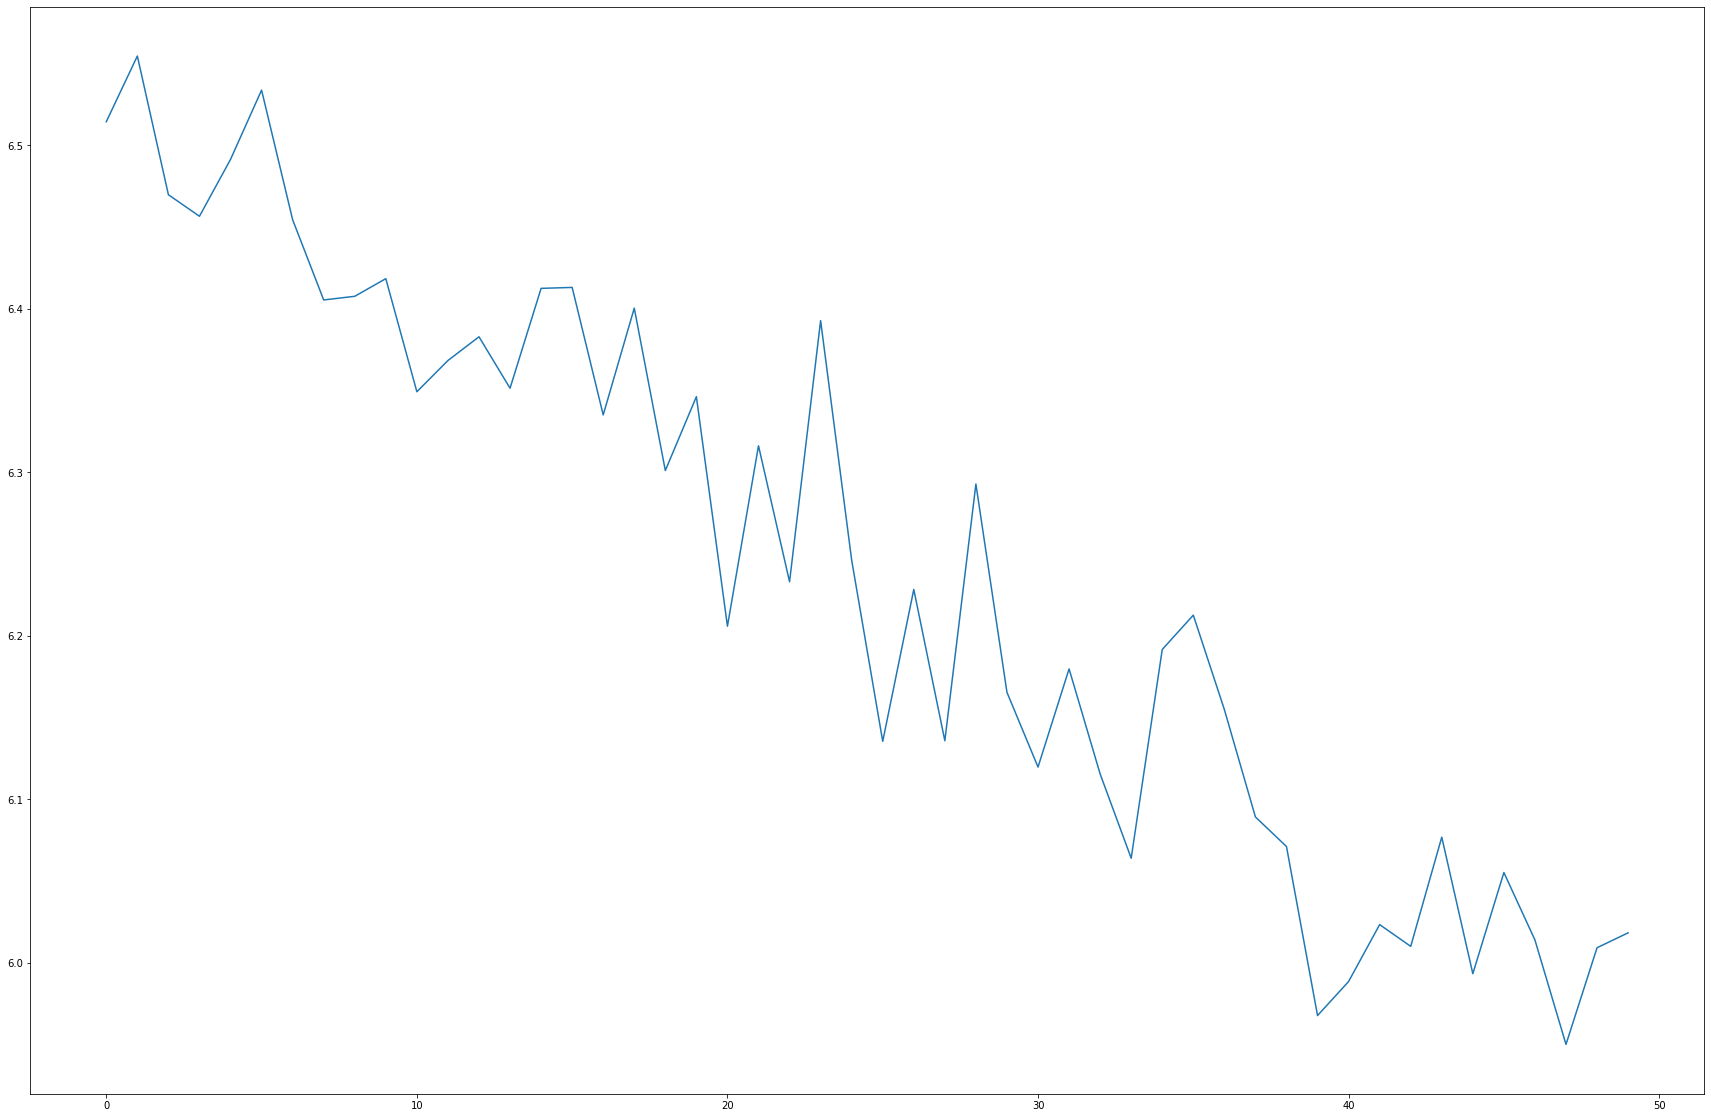

In [297]:
# plt.figure(0)
plt.plot(np.arange(0,nb_epoch),train_losses_epoch)

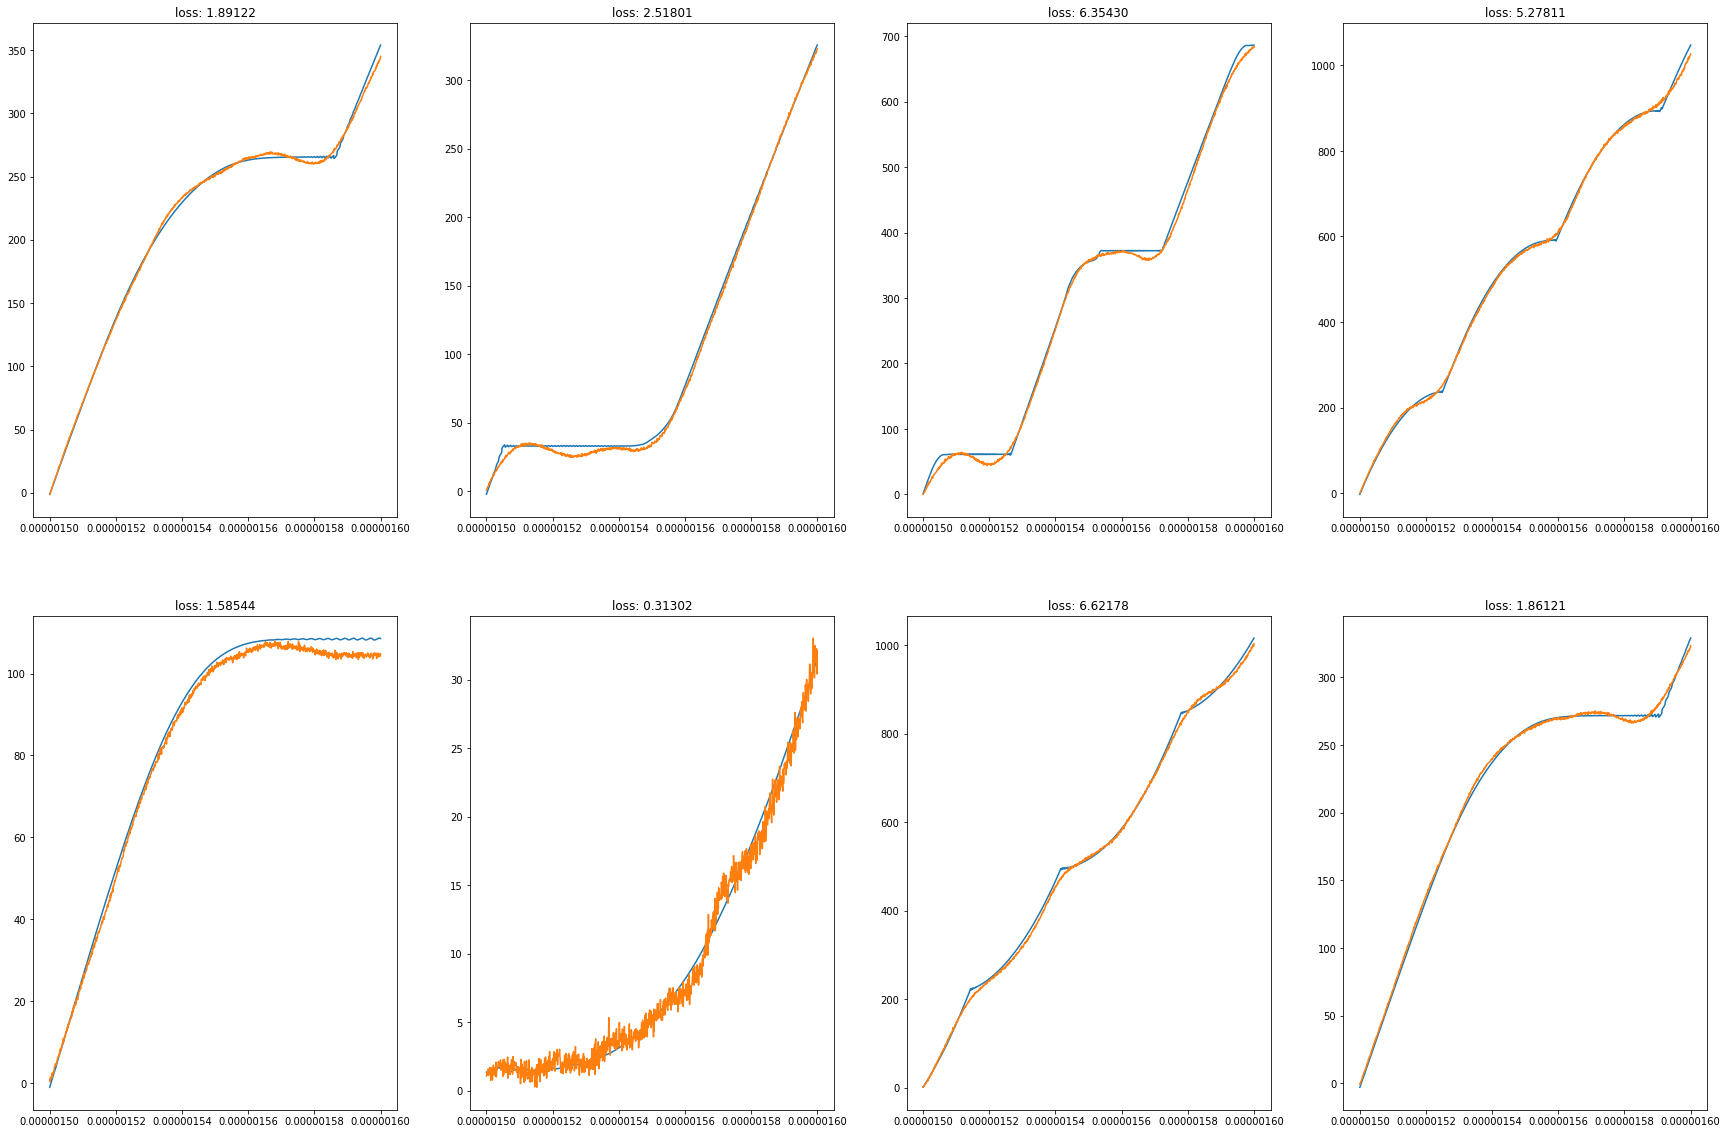

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

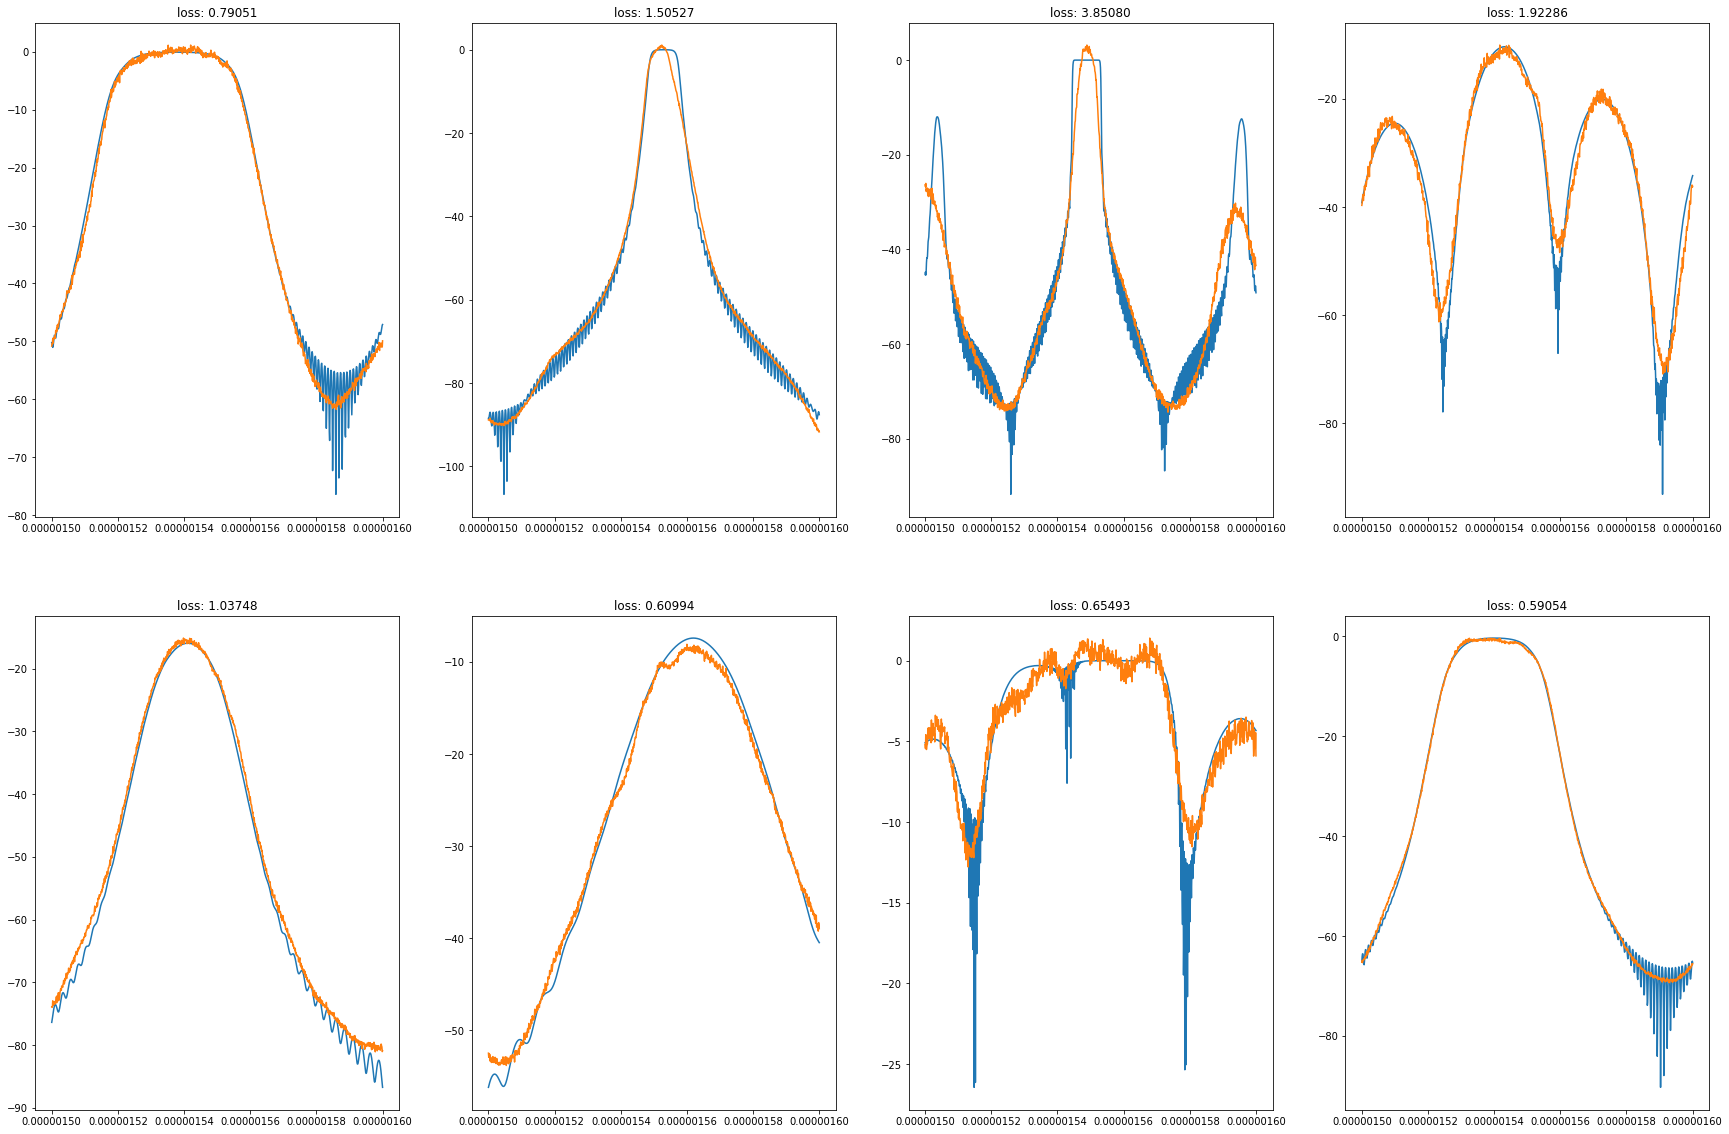

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

In [299]:
## EVALUATION
# model = DenseNet(1001,batch_size)
# model.load_state_dict(torch.load("DenseNet_t0_dB"))
model.eval()

# dataset_test = CDCDataset("JC/Data/Dataset_v0.txt","test")
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1)

all_predictions1 = []
all_target1 = []
all_predictions2 = []
all_target2 = []
all_loss1 = []
all_loss2 = []
for i_batch, batch in enumerate(test_loader):
    images, targets = batch
    images = images.to(device)
    targets = targets.type(torch.FloatTensor)
    targets = targets.to(device) 
    with torch.no_grad():
        target1 = targets[:,0:1001]
        target2 = targets[:,1001:2002]
        predictions1,predictions2 = model.forward(images)
        loss1 = criterion(predictions1, target1) 
        loss2 = criterion(predictions2, target2)        
        loss = loss1+loss2            
    all_loss1.append(loss1.item())
    all_loss2.append(loss2.item())
    all_predictions1.append(predictions1.cpu().numpy())
    all_target1.append(target1.cpu().numpy())
    all_predictions2.append(predictions2.cpu().numpy())
    all_target2.append(target2.cpu().numpy())


jd = 0
lambda_ = np.linspace(1500e-9,1600e-9,1001)
matplotlib.rcParams['figure.figsize'] = (30, 20)
fig, subfigs = plt.subplots(2, 4)
idx = np.random.randint(0,len(test_loader),8)
for subfig,kd in zip(subfigs.reshape(-1),idx): 
        subfig.plot(lambda_,(all_target2[kd][jd]))
        subfig.plot(lambda_,(all_predictions2[kd][jd]))  
        subfig.set_title('loss: {:.5f}'.format(all_loss2[kd]))
        plt.figure(figsize=(40,20))
plt.show()
fig, subfigs = plt.subplots(2, 4)       
for subfig,kd in zip(subfigs.reshape(-1),idx): 
        subfig.plot(lambda_,(all_target1[kd][jd]))
        subfig.plot(lambda_,(all_predictions1[kd][jd]))  
        subfig.set_title('loss: {:.5f}'.format(all_loss1[kd]))
        plt.figure(figsize=(40,20))
plt.show()
